<a href="https://colab.research.google.com/github/siruku6/thesis-trial/blob/master/reinforcement_learning/250330_torch_trial_for_advantage_log_prob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 深層強化学習で用いられる数学的な計算の動作確認 - exp, log, gaussian, log_prob

- Advantage を使って強化学習エージェントを学習させる際の、Action の対数確率密度を計算する方法をここに記録しておきます。
    - 行動空間は離散的 (descrete) ではなく、**連続的 (continuous)** な空間とします。
- 確率密度 log_prob の計算のみ notebook に記載しています。

In [ ]:
!pip list | grep torch
!python --version

torch                              2.6.0+cu124
torchaudio                         2.6.0+cu124
torchsummary                       1.5.1
torchvision                        0.21.0+cu124
Python 3.11.11


In [1]:
import math

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.distributions import Normal


# 3次元可視化用のメソッド

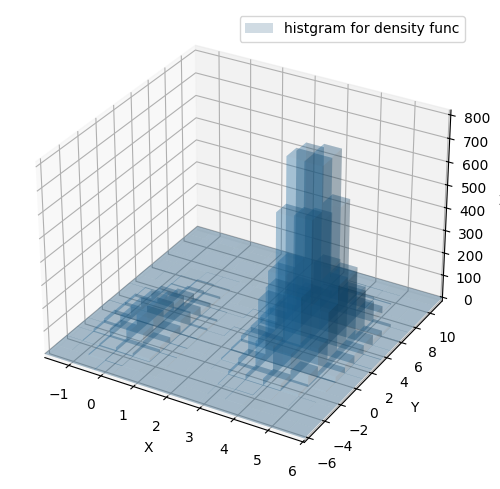

((11000,), (11000,))

In [7]:
np.random.seed(3)
x0 = np.random.randn(10000)*0.5 + 4 #標準偏差0.5, 平均4の正規分布
y0 = np.random.randn(10000)*2   + 3 #標準偏差2.0, 平均3の正規分布
x1 = np.random.randn(1000)*0.5 + 0 #標準偏差0.5, 平均0の正規分布
y1 = np.random.randn(1000)*2   + 0 #標準偏差2.0, 平均0の正規分布

x=np.concatenate((x0,x1))
y=np.concatenate((y0,y1))


def plot_3d_hist(x, y, ax = None, bin_size: int = 15, density = False) -> None:
    """
    2次元の分布データから3次元ヒストグラムを描画
    https://phst.hateblo.jp/entry/2023/02/24/080000

    Parameters
    ------
    x: 1次元配列
    y: 1次元配列
    """
    # 描画データの準備
    _xrange = [min(x),max(x)]
    _yrange = [min(y),max(y)]
    bins = [bin_size, bin_size]
    N: int = bins[0] * bins[1]
    wbins = [(_xrange[1] - _xrange[0]) / bins[0], (_yrange[1] - _yrange[0]) / bins[1]]

    hist, edgesx, edgesy = np.histogram2d(x, y, bins=bins, range=[_xrange, _yrange])
    hist = np.flipud(np.rot90(hist)) # histogram2d 出力の仕様由来のおまじない

    if density:
        bin_area = wbins[0] * wbins[1]  # 各ビンの面積
        hist /= (hist.sum() * bin_area)  # ビンの面積を考慮して正規化

    xpos, ypos = np.meshgrid(edgesx[:-1], edgesy[:-1])
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    zpos = np.array([0] * N)

    dx = np.array([wbins[0]] * N)
    dy = np.array([wbins[1]] * N)
    dz = hist.flatten()


    if ax is None:
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(projection='3d')

    # ax.bar3d(x=xpos[dz>0], y=ypos[dz>0], z=zpos[dz>0], dx=dx[dz>0], dy=dy[dz>0], dz=dz[dz>0], shade=True)
    ax.bar3d(x=xpos, y=ypos, z=zpos, dx=dx, dy=dy, dz=dz, shade=True, alpha=0.2, label="histgram for density func")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(*_xrange)
    ax.set_ylim(*_yrange)

plot_3d_hist(x,y)
plt.legend()
plt.show()

x.shape, y.shape


# 5. 1次元正規分布の対数確率密度

## 5-1. Action を単純に正規分布からサンプリング

In [ ]:
mean = 4
std = 0.8
norm_dist = Normal(mean, std)

# 正規分布から行動をサンプリング
actions = norm_dist.sample(torch.Size([100]))
actions.shape


torch.Size([100])

In [ ]:
# 対数確率密度を計算
log_probs = norm_dist.log_prob(actions)

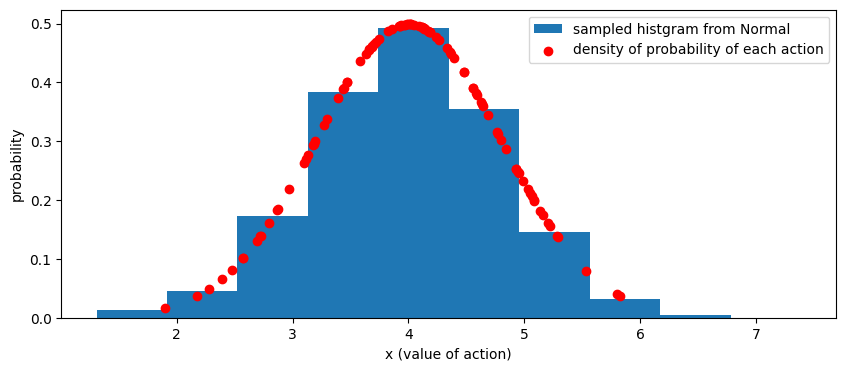

In [ ]:
# 対数確率密度を描画して比較できるようにするため、確率密度に変換
probs = log_probs.exp()

# 比較対象として、行動のサンプルを大量に取得 (histgram にする)
sampled_actions = norm_dist.sample(torch.Size([5000]))


# 描画処理
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# pytorch の Normal からのサンプリング結果をヒストグラムとして描画
ax.hist(sampled_actions, density=True, label="sampled histgram from Normal");

# スクラッチ実装の正規分布をプロット
plt.scatter(actions, probs, color='red', label='density of probability of each action')

plt.xlabel("x (value of action)")
plt.ylabel("probability")
plt.legend()

## 5-2. Action を出力する際に、正規分布からサンプリングした値を tanh 関数に通して Action とする

In [ ]:
mean = 5
std = 0.2
norm_dist = Normal(mean, std)

# 正規分布から x をサンプリング
x = norm_dist.sample(torch.Size([100]))

# 行動に変換
actions_tanh = torch.tanh(x)
actions_tanh.shape

torch.Size([100])

In [ ]:
# 対数確率密度を計算
log_prob_raw = norm_dist.log_prob(x)
correction = torch.log(1 - actions_tanh.pow(2) + 1e-6)  #.sum(dim=-1, keepdim=True)
log_prob_corrected = log_prob_raw - correction

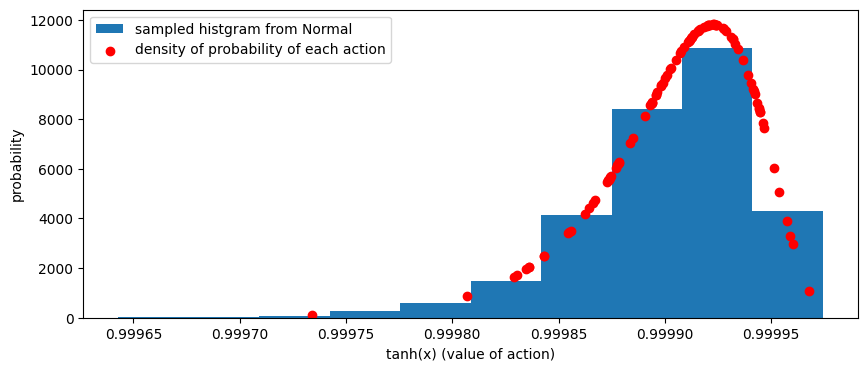

In [ ]:
# 描画準備
# 比較できるように、対数を外す
prob_corrected = log_prob_corrected.exp()

# 比較対象として、大量の行動をサンプリング
sampled_actions = norm_dist.sample(torch.Size([5000]))
sampled_actions_tanh = torch.tanh(sampled_actions)

# 描画
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# pytorch の Normal から大量サンプリングした行動をヒストグラムとして描画
ax.hist(sampled_actions_tanh, density=True, label="sampled histgram from Normal");

# log_prob 経由で取得した、各行動の確率密度を描画
plt.scatter(actions_tanh, prob_corrected, color='red', label='density of probability of each action')

plt.xlabel("tanh(x) (value of action)")
plt.ylabel("probability")
plt.legend()

# 6. 多次元正規分布からサンプリングしている場合


## シンプルな確率密度 (1次元だけ取り出し)

In [2]:
mean = torch.Tensor([1, 3])
std = torch.Tensor([0.15, 0.055]) + 1e-8
norm_dist = Normal(mean, std)

# 正規分布から x をサンプリング
actions = norm_dist.sample(torch.Size([800]))
actions.shape


torch.Size([800, 2])

### 対数確率密度の計算

In [3]:
log_probs = norm_dist.log_prob(actions)


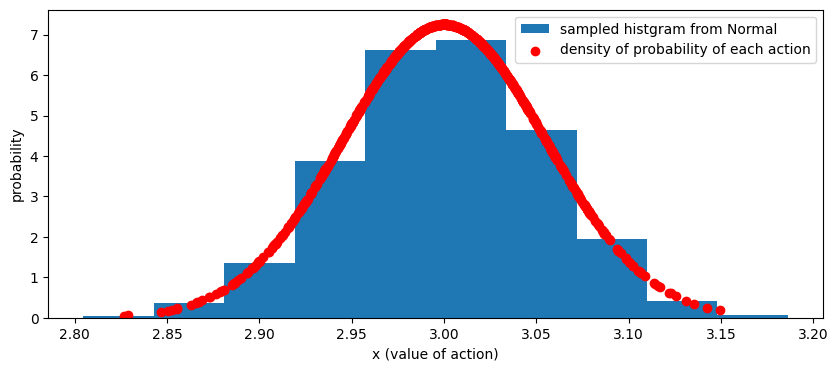

In [4]:
# 比較できるように、対数を外す
probs = log_probs.exp()

# 比較対象として、大量の行動をサンプリング
sampled_actions = norm_dist.sample(torch.Size([5000]))

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# 第1次元のデータだけを描画
# pytorch の Normal からのサンプリング結果をヒストグラムとして描画
ax.hist(sampled_actions[:, 1], density=True, label="sampled histgram from Normal");

# スクラッチ実装の正規分布をプロット
plt.scatter(actions[:, 1], probs[:, 1], color='red', label='density of probability of each action')

plt.xlabel("x (value of action)")
plt.ylabel("probability")
plt.legend()

## 6-1. Action を単純に正規分布からサンプリング

2次元分の行動の sum をとって確率密度とします。


In [5]:
log_probs = norm_dist.log_prob(actions).sum(dim=-1, keepdim=True)
# log_probs

torch.Size([800]) torch.Size([800]) torch.Size([800, 1])


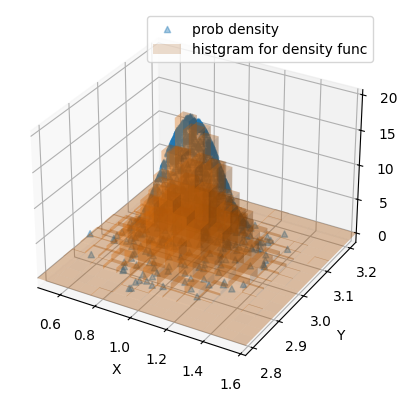

In [8]:
# 描画準備
xs = actions[:, 0]
ys = actions[:, 1]
# 比較できるように、対数を外す
zs = log_probs.exp()
print(xs.shape, ys.shape, zs.shape)

# 比較対象として、大量の行動をサンプリング
sampled_actions = norm_dist.sample(torch.Size([5000]))

# https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs.flatten(), marker='^', alpha=0.4, label="prob density")

plot_3d_hist(sampled_actions[:, 0], sampled_actions[:, 1], ax=ax, density=True)
plt.legend()
plt.show()


In [25]:
# plot_3d_hist(sampled_actions[:, 0], sampled_actions[:, 1], density=True)
# plt.legend()
# plt.show()


## 6-2. Action を出力する際に、正規分布からサンプリングした値を tanh 関数に通して Action とする

In [21]:
mean = torch.Tensor([1, 3])
std = torch.Tensor([0.15, 0.055]) + 1e-8
log_stds = torch.log(std)

# 正規分布から x をサンプリング
norm_dist = Normal(mean, std)
z_raw_actions = norm_dist.rsample(torch.Size([500]))

# tanh を使って行動へと変換
actions = torch.tanh(z_raw_actions)
actions.shape  # , actions

# ---- 出力結果 ----

torch.Size([500, 2])

In [22]:
# 対数確率密度を計算
log_prob_z = norm_dist.log_prob(z_raw_actions).sum(dim=-1, keepdim=True)

# サンプリング後の値 z を tanh に通していることを考慮した補正項
correction = torch.log(1 - actions.pow(2) + 1e-8).sum(dim=-1, keepdim=True)  # tanh'(z) = 1 - tanh^2(z)
log_prob_a = log_prob_z - correction

# 描画準備
# 比較できるように、対数を外す
prob_corrected = log_prob_a.exp()
# print(log_prob_a, correction,  prob_corrected)
prob_corrected.shape # , log_prob_a

torch.Size([500, 1])

In [23]:
# 比較対象として、大量の行動をサンプリング
sampled_actions = norm_dist.rsample(torch.Size([5000]))
sampled_actions_tanh = torch.tanh(sampled_actions)
# sampled_actions_tanh

torch.Size([500]) torch.Size([500]) torch.Size([500, 1])


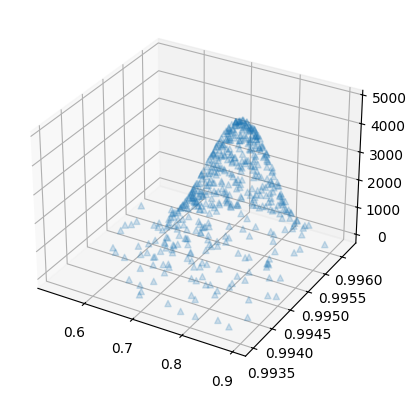

In [24]:
# 描画
xs = actions[:, 0]
ys = actions[:, 1]
zs = prob_corrected

print(xs.shape, ys.shape, zs.shape)

# https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs.flatten(), marker='^', alpha=0.2)
plt.show()

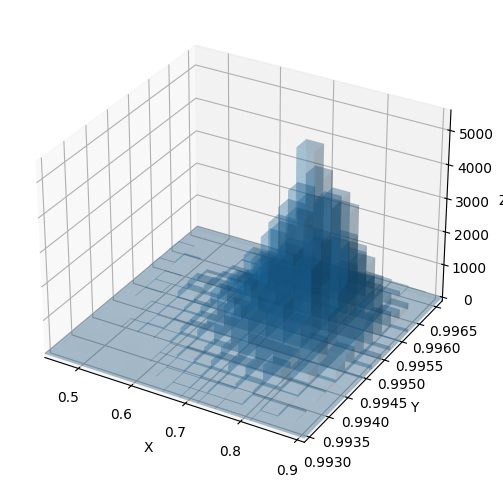

In [ ]:
# plot_3d_hist(prob_corrected[:, 0].numpy(), prob_corrected[:, 1].numpy())
plot_3d_hist(sampled_actions_tanh[:, 0].numpy(), sampled_actions_tanh[:, 1].numpy(), density=True)
# sampled_actions_tanh

torch.Size([200]) torch.Size([200]) torch.Size([200, 1])


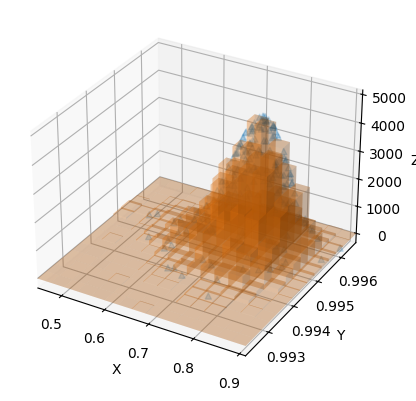

In [19]:
# 描画
xs = actions[:, 0]
ys = actions[:, 1]
zs = prob_corrected

print(xs.shape, ys.shape, zs.shape)

# https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs.flatten(), marker='^', alpha=0.2)

plot_3d_hist(sampled_actions_tanh[:, 0].numpy(), sampled_actions_tanh[:, 1].numpy(), ax=ax, density=True)

plt.show()